

## Class Activation Map
Class activation maps are obtained by making use of a Global Average Pooling (GAP) layer after the final convolutional layer and just before the softmax classification layer. A GAP layer takes averages across all the pixels at the output of the last convolutional layer, for each feature. For example, if the size of the output of the last convolutional layer is 7x7x128, then the GAP layer output will have a size of 1x1x128, which means that the GAP layer has computed the average of the 7x7 block of each of the 128 features, and has produced a layer flat layer of 128 neurons. These 128 neurons have to be connected to the softmax layer having 10 units (if the classification problem has 10 classes). So, if, for example, softmax output is maximum for class 6, then there will be 128 weights corresponding to the connections between the 128 neurons to softmax unit of class 6.  This is the weight vector for class 6, and it has a length of 128. The input to the GAP layer has size 7x7x128, i.e. there are 128 7x7 feature blocks. Now assume that the input image has size 28x28. In class activation map, we are trying to study the contribution of each pixel in the input image to the feature map and the selected class. So, the 7x7 feature block is zoomed (interpolated) to size 28x28. So after zooming, the feature map now has 128 28x28 blocks. Now consider a vector formed by taking the top-left pixel values of all these 128 blocks. This vector will have size 128. The inner product of this vector is computed with the weight vector to obtain the relevance of the top-left pixel to class 6. Similarly, the dot product computation is repeated for all the pixels in the zoomed feature block of size 28x28. The dot product matrix for all 28x28 pixels forms the Class Activation Map.

## Global Average Pooling (quote from original paper)

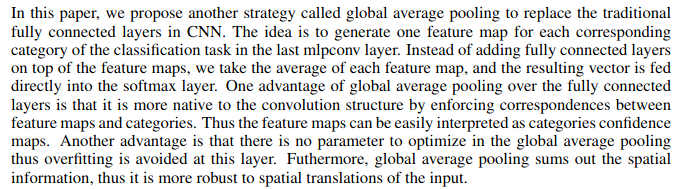

## Diagram for Global Average Pooling

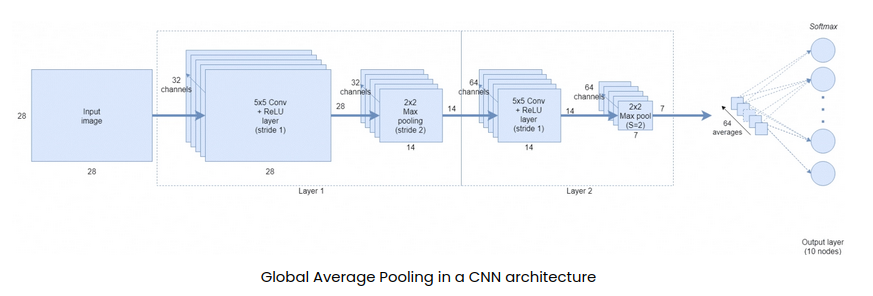

## Imports

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

### Download and Prepare the Dataset

Use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [ ]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

The cell below will preprocess the images and create batches before feeding it to the model.

In [ ]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

## Build the classifier

The output is just one unit having sigmoid activation, because only two classes are considered.

In [ ]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

## Training

In [ ]:
# Training will take around 30 minutes to complete using a GPU. 

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches,epochs=25)

## Building the CAM model



In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
print(gap_weights.shape)

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]
  print(class_activation_weights.shape)

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  print(class_activation_features.shape)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


## Testing the Model

Let's download a few images and see how the class activation maps look like.

In [ ]:

!wget -O cat1.jpg https://compote.slate.com/images/df91f4de-332e-4961-afb7-415ac019f18b.jpg
!wget -O cat2.jpg https://d2zp5xs5cp8zlg.cloudfront.net/image-31454-800.jpg
!wget -O dog1.jpg https://ggsc.s3.amazonaws.com/images/made/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner_600_400_int_c1-2x.jpg
!wget -O dog2.jpg https://images.newscientist.com/wp-content/uploads/2022/04/05152010/SEI_97255351.jpg
!wget -O dog3.jpg https://static.toiimg.com/thumb/msid-87920354,imgsize-45612,width-400,resizemode-4/87920354.jpg
!wget -O dog4.jpg https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg


--2022-07-05 15:25:12--  https://compote.slate.com/images/df91f4de-332e-4961-afb7-415ac019f18b.jpg
Resolving compote.slate.com (compote.slate.com)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to compote.slate.com (compote.slate.com)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24429 (24K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>]  23.86K  --.-KB/s    in 0.002s  

2022-07-05 15:25:12 (11.4 MB/s) - ‘cat1.jpg’ saved [24429/24429]

--2022-07-05 15:25:12--  https://d2zp5xs5cp8zlg.cloudfront.net/image-31454-800.jpg
Resolving d2zp5xs5cp8zlg.cloudfront.net (d2zp5xs5cp8zlg.cloudfront.net)... 18.67.3.196, 18.67.3.190, 18.67.3.160, ...
Connecting to d2zp5xs5cp8zlg.cloudfront.net (d2zp5xs5cp8zlg.cloudfront.net)|18.67.3.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71528 (70K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]  69.8

(128,)
(300, 300, 128)
sigmoid output: [[0.15045959]]
prediction: cat


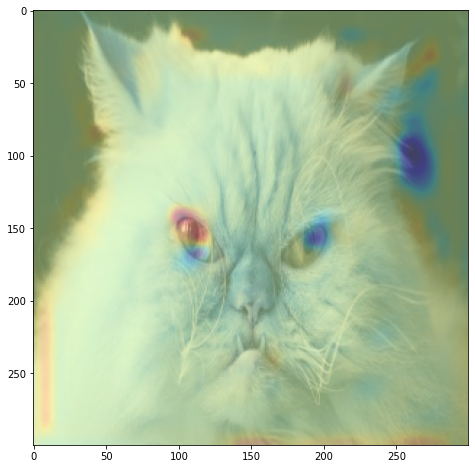

(128,)
(300, 300, 128)
sigmoid output: [[0.00273106]]
prediction: cat


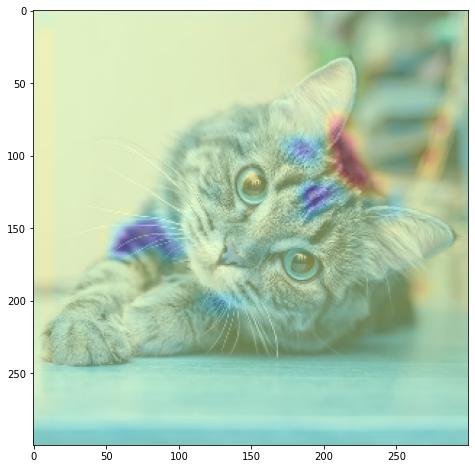

(128,)
(300, 300, 128)
sigmoid output: [[0.75973076]]
prediction: dog


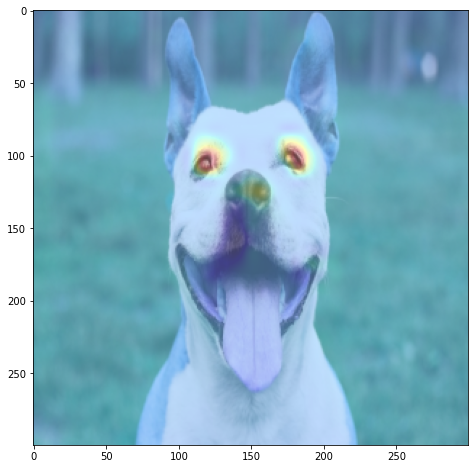

(128,)
(300, 300, 128)
sigmoid output: [[0.617073]]
prediction: dog


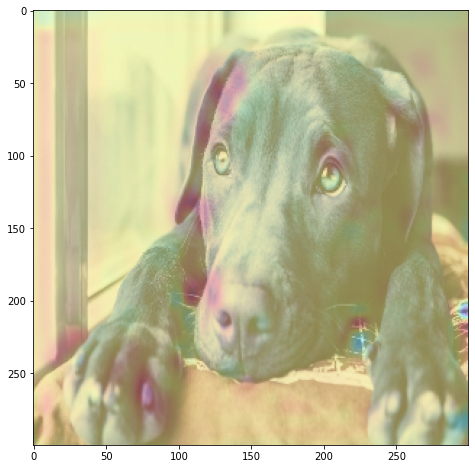

(128,)
(300, 300, 128)
sigmoid output: [[0.48167118]]
prediction: cat


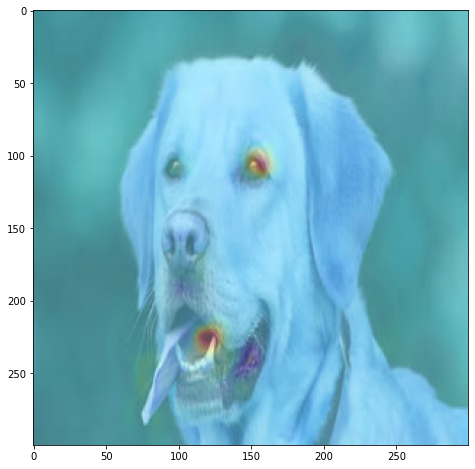

(128,)
(300, 300, 128)
sigmoid output: [[0.31493327]]
prediction: cat


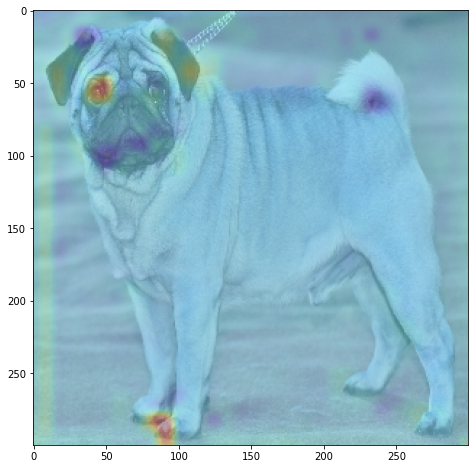

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')
convert_and_classify('dog3.jpg')
convert_and_classify('dog4.jpg')

## Test images

ground truth: cat
(128,)
(300, 300, 128)
sigmoid output: [[0.01502739]]
prediction: cat


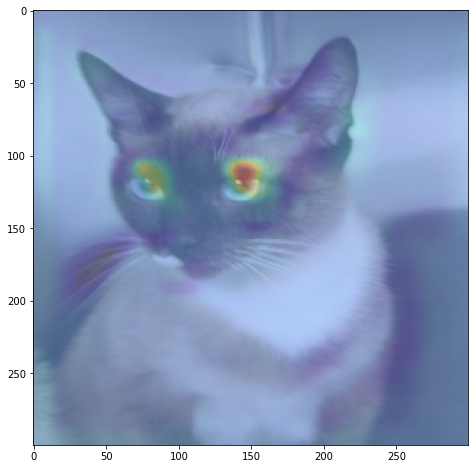

ground truth: dog
(128,)
(300, 300, 128)
sigmoid output: [[0.03350144]]
prediction: cat


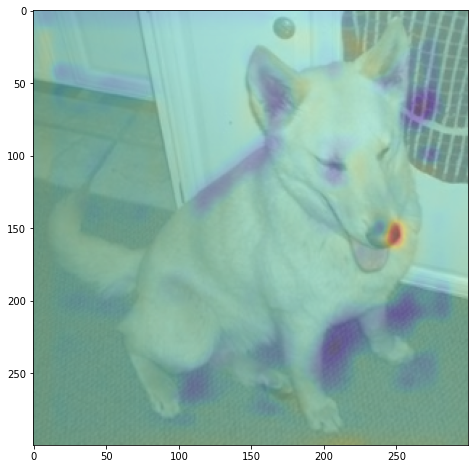

ground truth: dog
(128,)
(300, 300, 128)
sigmoid output: [[0.01963849]]
prediction: cat


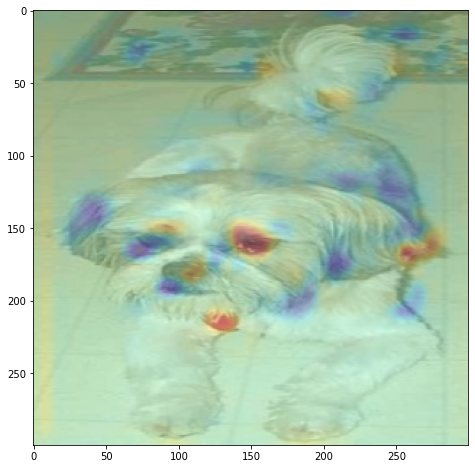

ground truth: cat
(128,)
(300, 300, 128)
sigmoid output: [[0.00024311]]
prediction: cat


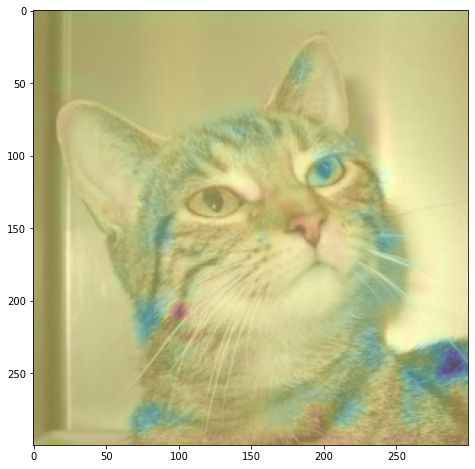

ground truth: cat
(128,)
(300, 300, 128)
sigmoid output: [[0.05837605]]
prediction: cat


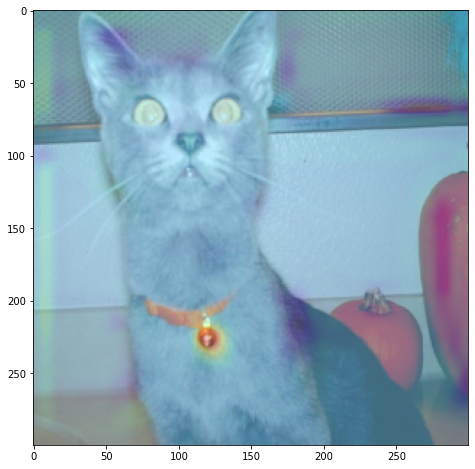

In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)